<a href="https://colab.research.google.com/github/unknown-jun/NLP_study/blob/main/NLP_Book/B07_%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%84%B1%EB%8A%A5_%EC%B5%9C%EC%A0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 배치 정규화

In [ ]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 데이터셋 다운로드
trainset = torchvision.datasets.FashionMNIST(
                          root = '/content/data',
                          train = True,
                          download=True,
                          transform = transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/FashionMNIST/raw



In [ ]:
# 데이터셋을 메모리로 가져오기
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
# 데이터셋 분리
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
6


torch.Size([4,1,28,28])  
- 4: 한번의 배치크기로 몇개의 데이터로 가져오는지를 의미함
- 1: 채널의 의미하는 것으로 흑백 이미지는 1, 컬러 이미지는 3을 출력한다.
- 28,28: 28 × 28(너비 × 높이) 픽셀 크기의 이미지라는 의미

In [ ]:
# 이미지 데이터를 출력하기 위한 전처리
def imshow(img, title):
  plt.figure(figsize=(batch_size*4, 4)) # 출력할 개별 이미지의 크기 지정
  plt.axis('off')
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.title(title)
  plt.show()

`plt.imshow(np.transpose(img, (1, 2, 0)))`
- 파이토치는 이미지 데이터셋을 [배치크기, 채널, 너비, 높이] 순서대로 저장함
- 그러나 matplotlib에서 출력하기 위해선 이미지가 [너비, 높이, 채널]의 형태가 되어야 함
- 즉, 데이터 형태의 변형이 필요한데 이때 사용할 수 있는 것이 `np.transpose()`

In [ ]:
# 이미지 데이터 출력 함수
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))   # 이미지의 크기는 (4, 28, 28, 1(배치크기, 높이, 너비, 채널))이 된다.
  img = torchvision.utils.make_grid(images) # 좌표에 이미지 픽셀을 대응시켜 그리드 형태로 출력
  imshow( img, title=[str(x.item()) for x in labels] )
  # imshow 함수를 사용함으로써 데이터의 형태는 (채널, 높이, 너비)에서 (높이, 너비, 채널)로 변경됌

  return images, labels

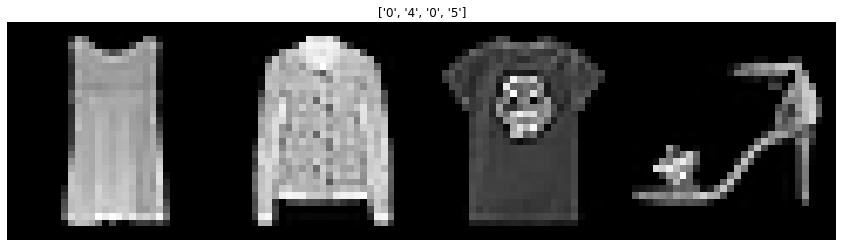

In [ ]:
# 이미지 출력
images, labels = show_batch_images(trainloader)

In [ ]:
# 배치 정규화가 적용되지 않은 네트워크
class NormalNet(nn.Module):
  def __init__(self):
    super(NormalNet, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(784, 48),         # (28, 28) 크기의 이미지로 입력은 784(28 x 28)
        nn.ReLU(),
        nn.Linear(48, 24),
        nn.ReLU(),
        nn.Linear(24, 10)           # FashionMNIST의 클래스는 10개
    )   # nn.Sequential을 사용하면 forward() 함수에서 계층(layer)별로 가독성 있게 코드 구현이 가능

  def forward(self, x):
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

In [ ]:
# 배치 정규화가 포함된 네트워크
class BNNet(nn.Module):
  def __init__(self):
    super(BNNet, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(784, 48),
        nn.BatchNorm1d(48),
        nn.ReLU(),
        nn.Linear(48, 24),
        nn.BatchNorm1d(24),
        nn.ReLU(), 
        nn.Linear(24, 10)
    )
  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

BatchNorm1d에서 사용되는 파라미터는 특성 개수로 이전 계층의 출력 채널이 된다.
- 배치 정규화를 사용하는 이유는 은닉층에서 학습이 진행될 때마다 입력 분포가 변하면서 가중치가 엉뚱한 방향으로 갱신되는 문제가 종종 발생하기 때문
- 배치 정규화를 적용하면 입력 분포를 고르게 맞추어 줄 수 있다.
- 배치 정규화는 완전연결층과 합성곱층 뒤, 활성화 함수 앞에 위치한다.

In [ ]:
# 배치 정규화가 적용되지 않은 모델 선언
model = NormalNet().to(device)
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [ ]:
# 배치 정규화를 포함한 모델 선언
model_bn = BNNet().to(device)
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [ ]:
# 데이터셋 메모리로 불러오기
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)

In [ ]:
# 옵티마이저, 손실함수 지정
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

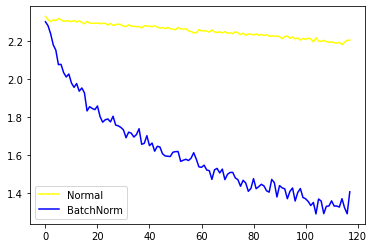

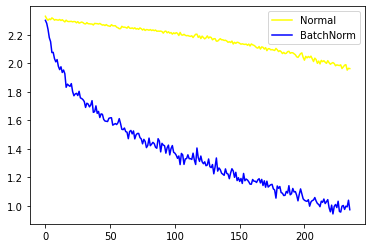

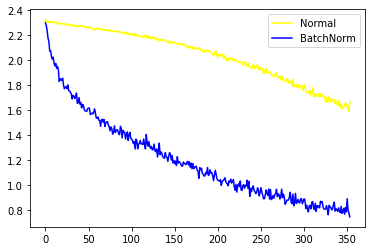

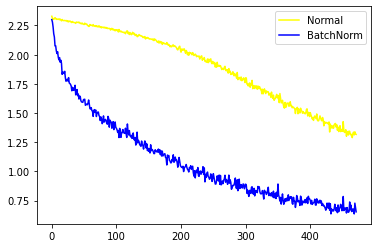

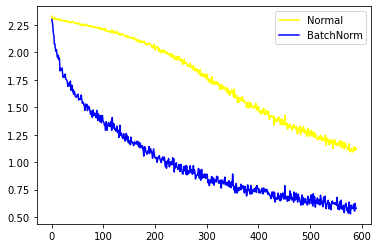

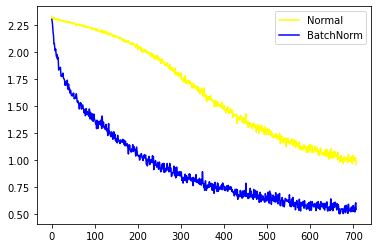

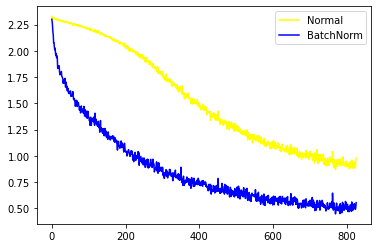

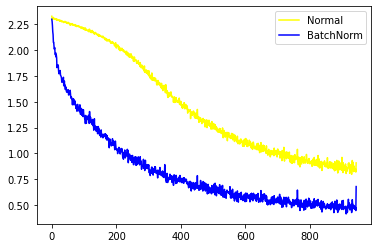

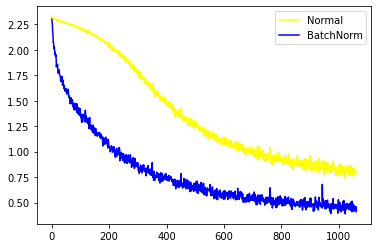

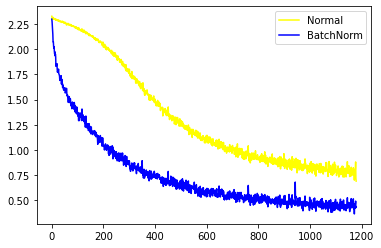

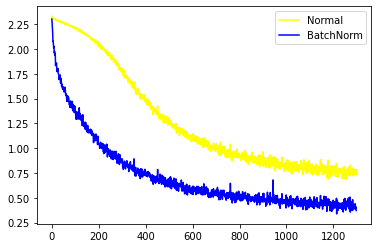

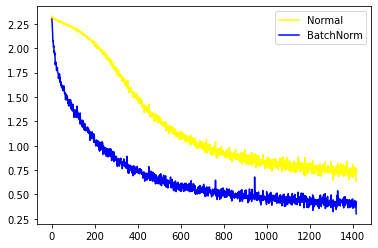

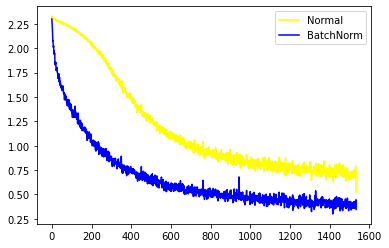

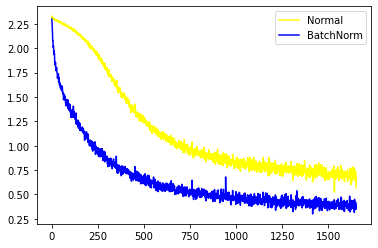

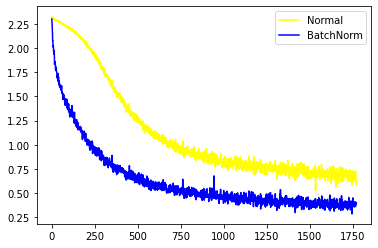

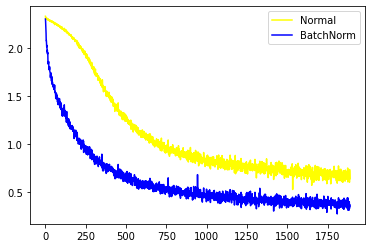

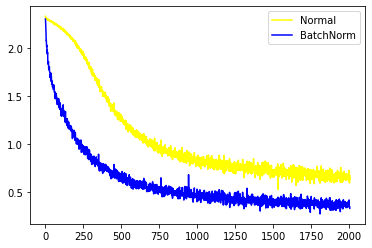

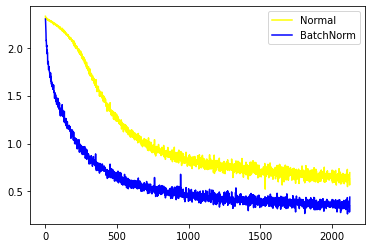

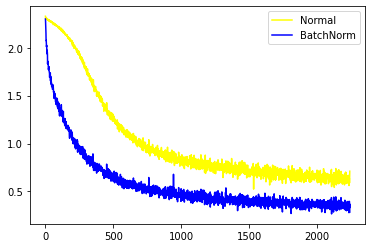

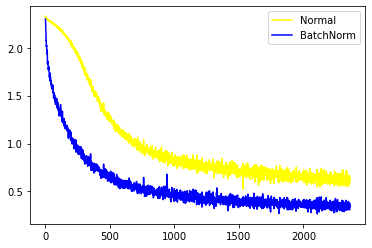

In [ ]:
# 모델 학습
loss_arr = []
loss_bn_arr= []
max_epochs = 20

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    outputs = model(inputs).to(device)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    opt_bn.zero_grad()
    outputs_bn = model_bn(inputs).to(device)
    loss_bn = loss_fn(outputs_bn, labels)
    loss_bn.backward()
    opt_bn.step()

    loss_arr.append(loss.item())
    loss_bn_arr.append(loss_bn.item())
  
  plt.plot(loss_arr, 'yellow', label='Normal')
  plt.plot(loss_bn_arr, 'blue', label='BatchNorm')
  plt.legend()
  plt.show()

In [ ]:
# 데이터셋의 분포를 출력하기 위한 전처리
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1,1,N),1)
y_train = x_train + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

`torch.unsqueeze(torch.linspace(-1,1,N),1)`:
- 훈련 데이터셋이 -1 ~ 1의 값을 갖도록 조정함
- `torch.linspace( )`는 주어진 범위에서 균등한 값을 갖는 텐서를 만들기 위해 사용함
  - 즉, `torch.linspace(-1,1,N)`의 의미는 -1~1의 범위에서 N개의 균등한 값을 갖는 텐서를 생성하겠다는 것
- `torch.unsqueeze()`는 차원을 증가 시키기 위해 사용함
  - 따라서 `torch.unsqueeze(torch.linspace(-1,1,N),1)`의 의미는 `torch.linspace(-1,1,N)` 텐서의 첫 번째 자리에서 차원을 증가시키겠다는 의미

`y_train = x_train + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))`:
- `torch.normal()`은 정규분포로부터 무작위 표본 추출을 위해 사용함
- `torch.normal(평균, 표준편차)`를 의미하기 때문에 `torch.zero()`는 평균, `torch.ones()`는 표준편차를 의미한다.

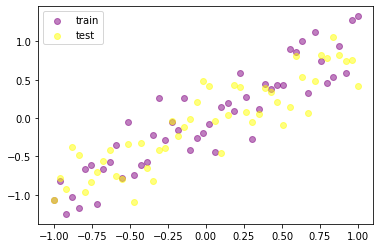

In [ ]:
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend();

In [ ]:
# 드롭아웃을 위한 모델 생성
N_h = 100

##### 드롭아웃을 적용되지 않은 모델 #####
model = nn.Sequential(
    nn.Linear(1, N_h),
    nn.ReLU(),
    nn.Linear(N_h, N_h),
    nn.ReLU(),
    nn.Linear(N_h, 1),
)  

##### 드롭아웃이 적용된 모델 #####
model_dropout = nn.Sequential(
    nn.Linear(1, N_h),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(N_h, N_h),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(N_h, 1),
)

In [ ]:
# 옵티마이저와 손실 함수 지정
opt = optim.Adam(model.parameters(), lr=0.01)
opt_dropout = optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

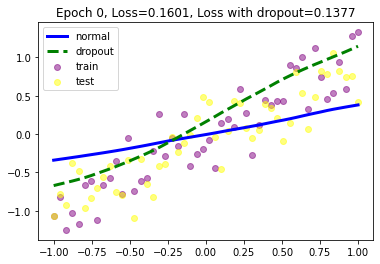

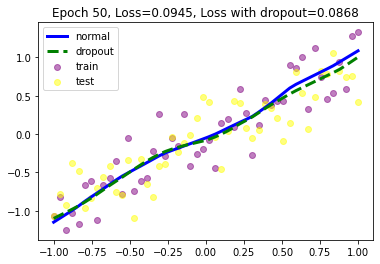

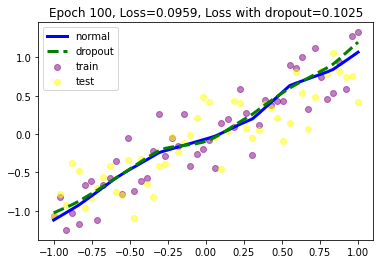

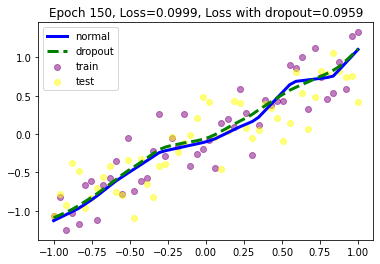

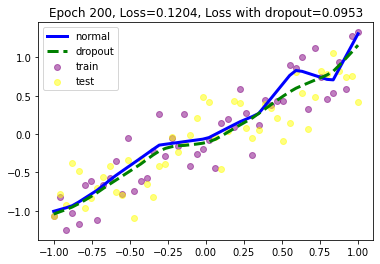

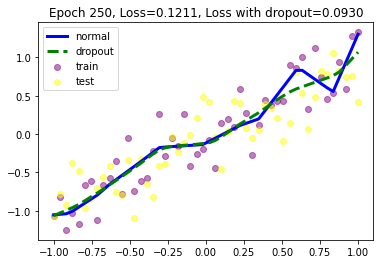

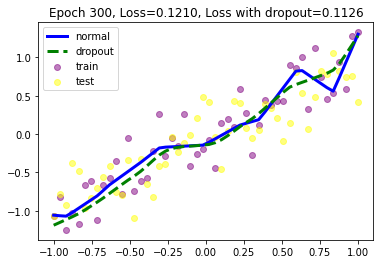

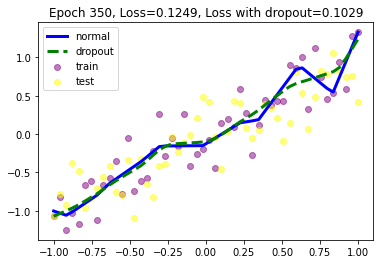

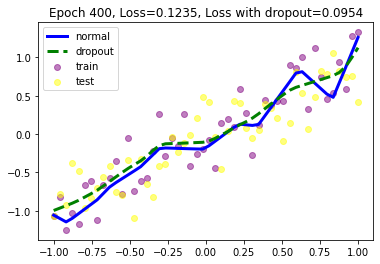

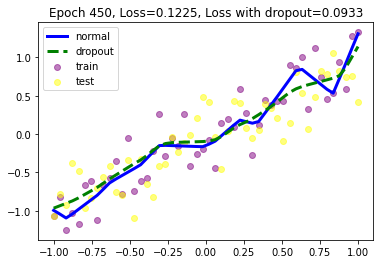

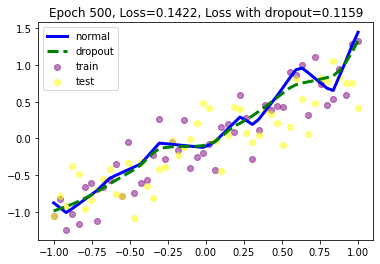

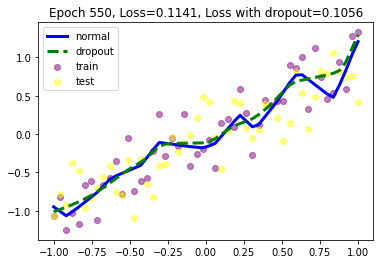

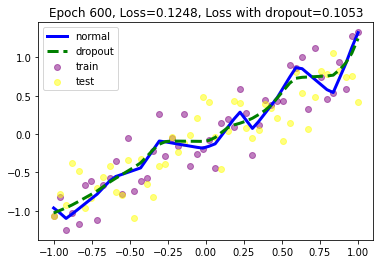

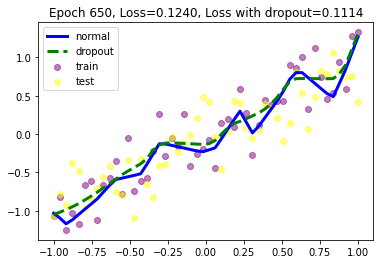

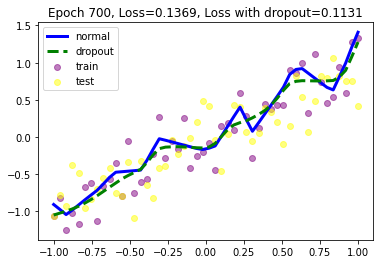

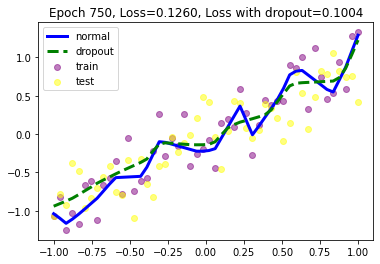

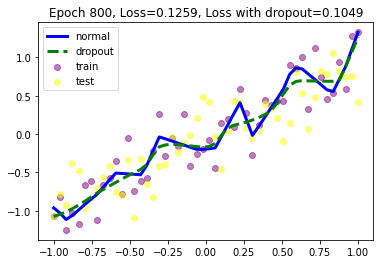

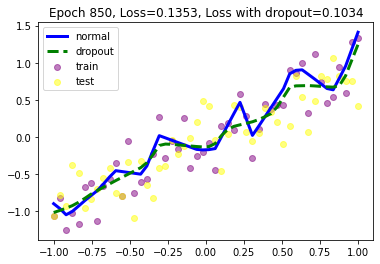

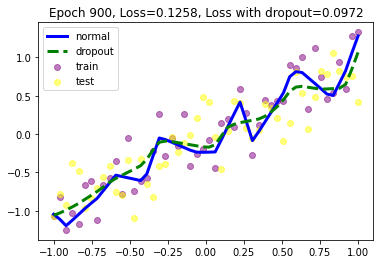

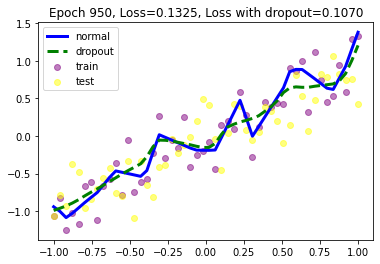

In [ ]:
# 모델 학습
max_epochs = 1000

for epoch in range(max_epochs):
  ### 드롭아웃이 적용되지 않은 모델 학습 ###
  pred = model(x_train)
  loss = loss_fn(pred, y_train)
  opt.zero_grad()
  loss.backward()
  opt.step()

  ### 드롭아웃이 적용된 모델 학습 ###
  pred_dropout = model_dropout(x_train)
  loss_dropout = loss_fn(pred_dropout, y_train)
  opt_dropout.zero_grad()
  loss_dropout.backward()
  opt_dropout.step()

  if epoch % 50 == 0:
    model.eval()
    model_dropout.eval()

    test_pred = model(x_test)
    test_loss = loss_fn(test_pred, y_test)

    test_pred_dropout = model_dropout(x_test)
    test_loss_dropout = loss_fn(test_pred_dropout, y_test)

    plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
    plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')

    plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
    plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3, label='dropout')
    
    plt.title('Epoch %d, Loss=%0.4f, Loss with dropout=%0.4f' % (epoch, test_loss, test_loss_dropout))
    plt.legend()

    model.train()
    model_dropout.train()
    plt.pause(0.05)

# 조기종료

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets

import matplotlib
import matplotlib.pyplot as plt

import time
import argparse
from tqdm import notebook

matplotlib.style.use('ggplot')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 데이터셋 전처리
train_transform = transforms.Compose([
                      transforms.Resize((224, 224)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
                      transforms.Resize((224, 224)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# 데이터셋 가져오기
train_dataset = datasets.ImageFolder(
    root=r'/content/gdrive/MyDrive/딥러닝 파이토치 교과서/train2',
    transform = train_transform
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

val_dataset = datasets.ImageFolder(
    root=r'/content/gdrive/MyDrive/딥러닝 파이토치 교과서/test2',
    transform = val_transform
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=True
)

In [ ]:
# 모델 생성
def resnet50(pretrained=True, requires_grad=False):
  model = models.resnet50(progress=True, pretrained=pretrained)
  if requires_grad == False:              # 파라미터를 고정하여 backward() 중에 기울기가 계산되지 않도록 함
    for param in model.parameters():      # requires_grad=False를 파라미터로 받았기 때문에 해당 구문이 실행
      param.requires_grad = False
  elif requires_grad == True:             # 파라미터 값이 backward() 중에 기울기 계산에 반영
    for param in model.parameters():      
      param.requires_grad = True
  model.fc = nn.Linear(2048, 2)           # 마지막 분류를 위한 계층은 학습을 진행함
  return model

##### 학습률 감소(learning rate decay)
- 학습률에 대한 값을 고정시켜서 모델을 학습하는 것이 아닌 학습이 진행되는 과정에서 학습률을 조금씩 낮추어 주는 성능 튜닝 기법 중 하나
- 학습률 감소는 학습률 스케줄러(learning rate scheduler)라는 것을 이용함
- 주어진 'patience' 횟수만큼 검증 데이터셋에 대한 오차 감소가 없으면 역시 주어진 'factor'만큼 학습률을 감소시켜 모델의 최적화가 가능하도록 도와줌

In [ ]:
# 학습률 감소
class LRScheduler():
  def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
    self.optimizer = optimizer
    self.patience = patience
    self.min_lr = min_lr
    self.factor = factor
    self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 
                                                                   mode = 'min',
                                                                   patience= self.patience,
                                                                   factor= self.factor,
                                                                   min_lr= self.min_lr,
                                                                   verbose= True)
  def __call__(self, val_loss):
    self.lr_scheduler.step(val_loss)

```
torch.optim.lr_scheduler.ReduceLR0nPlateau(self.optimizer, 
                                            mode='min', 
                                            patience= self.patience, 
                                            factor= self.factor,
                                            min_lr= self.min_lr,
                                            verbose= True)
```
- `lr_scheduler.ReduceLROnPlateau`: ReduceLROnPlateau는 검증 데이터셋에 대한 오차의 변동이 없으면 학습률을 factor배로 감소시킴
- `optimizer`: 파라미터(가중치)를 갱신시키는 부분으로, 여기에서는 아담(optim.Adam)을 사용함
- `mode`: 언제 학습률을 조정할지에 대한 기준이 되는 값.  
만약 검증 데이터셋에 대한 오차(val_loss)를 기준으로 사용하면 오차가 더 이상 감소되지 않을 때 학습률을 조정하게 된다. 
이 때 오차값이 최소(min)가 되어야 하는지, 최대(max)가 되어야 하는지 알려주는 파라미터가 mode.  
예를 들어 학습률 조정의 기준이 되는 값을 모델의 정확도(val_acc)로 사용하면 값이 클수록 좋기 때문에 'max'를 지정함.  
모델의 오차(val_loss)로 사용할 경우 작을수록 좋기 때문에 'min'을 지정한다.  
예제에서는 모델의 오차를 사용하기 때문에 'min'으로 지정
- `patience`: 학습률을 업데이트하기 전에 몇번의 에포크를 기다려야 하는지 결정하는 것으로, 여기에서는 다섯 번의 에포크를 기다리도록 설정 
- `factor`: 학습률을 얼마나 감소시킬지 지정하는 파라미터.  
새로운 학습률은 기존 학습률 * factor가 된다.  
예를 들어 현재 학습률이 0.01이고 factor가 0.5일 때, 콜백 함수가 실행된다면 그 다음 학습률은 0.005가 된다.
- `min_lr`: 학습률의 하한선을 지정함.  
예를 들어 현재 학습률이 0.1이고 factor가 0.5, min_lr이 0.03이라면 첫번째로 콜백 함수가 적용될 때 학습률의 하한선은 0.03×(0.1×0.5)처럼 계산된다.
- `verbose`: 조기종료의 시작과 끝을 출력하기 위해 사용.  
1로 설정할 경우 조기 종료가 적용되면 화면에 출력하지만, 0으로 설정하면 아무런 출력없이 학습을 종료함

```
def __call__(self, val_loss):
   self.lr_scheduler.step(val_loss)
```
- 실제로 학습률을 업데이트 함
- 에포크 단위로 검증 데이터셋에 대한 오차(val_loss)를 받아서 이전 오차와 비교했을 때 차이가 없다면 학습률을 업데이트 함

##### Note: 콜백(callback) 함수
- 개발자가 명시적으로 함수를 호출하는 게 아니라 개발자는 단지 함수 등록만 하고 특정 이벤트 발생에 의해 함수를 호출하고 처리하도록 하는 것이 콜백 함수.
- 콜백 함수는 동기적(synchronous) 함수와 비동기적(asynchronous) 함수가 있다.
- 동기적 함수는 코드가 위에서 아래로, 왼쪽에서 오른쪽으로 순차적으로 실행되는 함수
- 비동기적 함수는 병렬 처리와 같다고 이해할 수 있다.
- 어떤 코드를 실행했을 때 상당한 시간을 기다려야 하는 경우 해당 코드가 완료될 때까지 기다리는 것이 아닌 다른 코드가 먼저 처리되도록 하는 것이 비동기적 함수다.  

**=> 함수의 인자로 사용되는 함수를 callback 함수라고 한다.**
- MapReduce의 Map 함수, 공백을 기준으로 입력받아 int타입을 변환하는 Map 함수 같은 기능을 나타내며 이렇게 map(function, iterable)처럼 함수 내에서 함수를 인자로써 사용되는 함수를 콜백 함수라고 함

In [ ]:
##### callback 함수의 예 #####

def call_10_times(func):  # 함수의 인지로 함수를 쓴다: callback
  for i in range(10):
    func(i)

def print_hello(number):
  print('안녕하세요', number)

call_10_times(print_hello)

A, B = map(int, input().split())  # map은 대표적인 callback 함수: map이라는 함수 안에 input() 함수가 있음
print(A, B)

list(map(lambda x: x**2, range(5))) # map안에 람다식으로도 표현이 가능하다

안녕하세요 0
안녕하세요 1
안녕하세요 2
안녕하세요 3
안녕하세요 4
안녕하세요 5
안녕하세요 6
안녕하세요 7
안녕하세요 8
안녕하세요 9
3 4
3 4


[0, 1, 4, 9, 16]

In [ ]:
# 조기 종료
class EarlyStopping():
  def __init__(self, patience=5, verbose=False, delta=0, path='./content/checkpoint.pt'):
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_score = None       # 검증 데이터셋에 대한 오차 최적화 값
    self.early_stop = False      # 조기 종료를 의미하며 초깃값은 False로 설정
    self.val_loss_min = np.Inf   # np.Inf는 넘파이에서 무한대를 표현
    self.delta = delta
    self.path = path             # 모델링이 저장될 장소

  def __call__(self, val_loss, model):  # 에포크만큼 학습이 반복되면서 best_loss가 갱신되고, best_loss에 진전이 없으면 조기 종료한 후 모델을 저장
    score = -val_loss
    if self.best_score is None:         # best_score가 없을 때 실행
      self.best_score = score
      self.save_checkpoint(val_loss, model)
    
    elif score < self.best_score + self.delta:   # best_score + delta가 score보다 크면 실행
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        self.early_stop = True
    
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.counter = 0

  def save_checkpoint(self, val_loss, model):   # 검증 데이터셋에 대한 오차가 감소하면 모델을 저장
    if self.verbose:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
      torch.save(model.state_dict(), self.path)
      self.val_loss_min = val_loss

`self.patience = patience`:
- 오차 개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄지 지정함. 예제에서는 5라고 지정했기 때문에 개선이 없는 에포크는 다섯번 지속될 경우 학습을 종료함  

`self.delta = delta`:
- 오차가 개선되고 있다고 판단하기 위한 최소 변화량을 나타낸다. 변화량이 delta보다 적다면 개선이 없다고 판단함

예제에서는 학습률 감소와 조기 종료 두개에 대한 성능 튜닝을 진행하고 있다.  
즉, 함수에 넘겨주는 인수(argument) 값에 따라 다른 동작을 하도록 해야 하는데, 이때 사용할 수 있는 것이 argparse 라이브러리다.  
ArgumentParser()를 이용하여 변수와 타입을 정의해주고 add_argument()를 이용해서 변수에 인수 값을 하나씩 추가한다.  
그리고 마지막으로 parse_args()를 통해 사용자로부터 입력받은 값들을 args 변수에 저장한다.

In [ ]:
# 인수값 지정
parser = argparse.ArgumentParser()  # 인수값을 받을 수 있는 인스턴스 생성
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1") #주피터 노트북에서 실행할때 필요
args = vars(parser.parse_args())

`parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_ture')`:
- 원하는 인수 값을 추가한다. 이때 parser.add_argument()는 인수 개수만큼 만들어준다.  
  1. 첫번째 파라미터: 옵션 문자열의 이름으로 명령을 실행할 때 사용하는데 예를 들어 다음과 같다.  
  `> python main.py --lr-scheduler`
  2. dest: 입력값이 저장되는 변수. 예제의 경우 lr_scheduler 변수에 입력 값이 저장된다.
  3. action: action을 store_true로 지정하면 입력 값을 dest 파라미터에 의해 생성된 변수에 저장함.


`args = vars(parser.parse_args())`
- 입력받은 인수값(예: lr_scheduler)이 실제로 args 변수에 저장된다.

In [ ]:
!pip install ipywidgets

In [ ]:
# 사전 훈련된 모델의 파라미터 확인
print(f'Computation device: {device}\n')
model = models.resnet50(pretrained=True).to(device)

total_params = sum(p.numel() for p in model.parameters())     # 총 파라미터 수
print(f'{total_params:,} total parameters.')

total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)  # 학습 가능한 파라미터 수
print(f'{total_trainable_params:,} training parameters.')

Computation device: cuda:0



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

25,557,032 total parameters.
25,557,032 training parameters.


`torch.numel(input) → int`:
- input 텐서의 총 요소 수를 반환함.
```
>>> a = torch.zeros(4,4)
>>> torch.numel(a)
16
``` 

In [ ]:
# 옵티마이저와 손실 함수 지정
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

'--lr-scheduler' 또는 '--early-stopping'처럼 어떤 인수도 사용하지 않을 때 오차, 정확도 및 모델의 이름으로 사용할 문자열을 지정한다.

In [ ]:
# 오차, 정확도 및 모델의 이름에 대한 문자열
loss_plot_name = 'loss'     # 오차 출력에 대한 문자열
acc_plot_name = 'accuracy'  # 정확도 출력에 대한 문자열
model_name = 'model'        # 모델을 저장하기 위한 문자열

'--lr-scheduler' 또는 '--early-stopping' 인수를 사용할 경우 오차, 정확도 및 모델의 이름으로 사용할 문자열을 지정

In [ ]:
# 오차, 정확도 및 모델의 이름에 대한 문자열
if args['lr_scheduler']:
  print('INFO: Initializing learning rate scheduler')
  lr_scheduler = LRScheduler(optimizer)
  loss_plot_name = 'lrs_loss'     # 학습률 감소를 적용했을 때의 오차에 대한 문자열
  acc_plot_name = 'lrs_accuracy'  # 학습률 감소를 적용했을 때의 정확도에 대한 문자열
  model_name = 'lrs_model'        # 학습률 감소를 적용했을 때의 모델에 대한 문자열

if args['early_stopping']:
  print('INFO: Initializing early stopping')
  early_stopping = EarlyStopping()
  loss_plot_name = 'es_loss'      # 조기 종료를 적용했을 때의 오차에 대한 문자열
  acc_plot_name = 'es_accuracy'   # 조기 종료를 적용했을 때의 정확도에 대한 문자열
  model_name = 'es_model'         # 조기 종료를 적용했을 때의 모델에 대한 문자열

In [ ]:
# 모델 학습 함수
def training(model, train_dataloader,train_dataset, optimizer, criterion):
  print('Training')
  model.train()
  train_running_loss = 0.0
  train_running_correct = 0
  counter = 0
  total = 0
  prog_bar = notebook.tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))

  for i, data in prog_bar:
    counter += 1
    data, target = data[0].to(device), data[1].to(device)
    total += target.size(0)
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, target)
    train_running_loss += loss.item()
    _, preds = torch.max(outputs.data, 1)
    train_running_correct += (preds == target).sum().item()
    loss.backward()
    optimizer.step()

  train_loss = train_running_loss / counter
  train_accuracy = 100. * train_running_correct / total
  return train_loss, train_accuracy

In [ ]:
# 모델 검증 함수
def validation(model, test_dataloader, val_dataset, criterion):
  print("Validating")
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0
  counter = 0
  total = 0
  prog_bar = notebook.tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))

  with torch.no_grad():
    for i, data in prog_bar:
      counter += 1
      data, target = data[0].to(device), data[1].to(device)
      total += target.size(0)
      outputs = model(data)
      loss = criterion(outputs, target)

      val_running_loss += loss.item()
      _, preds = torch.max(outputs.data, 1)
      val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss / counter
    val_accuracy = 100. * val_running_correct / total
    return val_loss, val_accuracy

In [ ]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [],[]

start = time.time()
for epoch in range(epochs):
  print(f'Epoch {epoch+1}, of {epochs}')
  train_epoch_loss, train_epoch_accuracy = training(
      model, train_dataloader, train_dataset, optimizer, criterion
  )
  val_epoch_loss, val_epoch_accuracy = validation(
      model, val_dataloader, val_dataset, criterion
  )
  train_loss.append(train_epoch_loss)
  train_accuracy.append(train_epoch_accuracy)
  val_loss.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

  if args['lr_scheduler']:
    lr_scheduler(val_epoch_loss)
  if args['early_stopping']:
    early_stopping(val_epoch_loss, model)
    if early_stopping.early_stop:
      break

  print(f'Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}')
  print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')

end = time.time()
print(f'Training time: {(start-end)/60:.3f} minutes')

Epoch 1, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 2.1804, Train Acc: 56.43
Val Loss: 6.3175, Val Acc: 52.20
Epoch 2, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.4790, Train Acc: 78.51
Val Loss: 3.7282, Val Acc: 58.40
Epoch 3, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.4400, Train Acc: 81.73
Val Loss: 0.8077, Val Acc: 71.00
Epoch 4, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3713, Train Acc: 84.14
Val Loss: 0.4961, Val Acc: 77.00
Epoch 5, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2910, Train Acc: 87.95
Val Loss: 0.6424, Val Acc: 79.40
Epoch 6, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2966, Train Acc: 87.15
Val Loss: 0.5869, Val Acc: 78.20
Epoch 7, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2261, Train Acc: 92.37
Val Loss: 1.4636, Val Acc: 69.60
Epoch 8, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3451, Train Acc: 87.75
Val Loss: 0.9440, Val Acc: 74.00
Epoch 9, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3378, Train Acc: 85.34
Val Loss: 0.6101, Val Acc: 74.60
Epoch 10, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2413, Train Acc: 89.96
Val Loss: 0.7272, Val Acc: 72.60
Epoch 11, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2073, Train Acc: 91.97
Val Loss: 0.8699, Val Acc: 76.20
Epoch 12, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2537, Train Acc: 89.56
Val Loss: 1.4291, Val Acc: 70.40
Epoch 13, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2631, Train Acc: 90.76
Val Loss: 0.7348, Val Acc: 75.20
Epoch 14, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2224, Train Acc: 90.56
Val Loss: 0.5297, Val Acc: 78.20
Epoch 15, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1744, Train Acc: 93.98
Val Loss: 0.7905, Val Acc: 71.60
Epoch 16, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2188, Train Acc: 91.16
Val Loss: 0.9006, Val Acc: 75.20
Epoch 17, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1409, Train Acc: 94.18
Val Loss: 0.6537, Val Acc: 79.60
Epoch 18, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1193, Train Acc: 95.58
Val Loss: 0.8702, Val Acc: 74.40
Epoch 19, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1132, Train Acc: 95.98
Val Loss: 0.8468, Val Acc: 76.80
Epoch 20, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1074, Train Acc: 95.58
Val Loss: 0.8488, Val Acc: 77.00
Epoch 21, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1682, Train Acc: 94.38
Val Loss: 2.0784, Val Acc: 69.00
Epoch 22, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2115, Train Acc: 91.77
Val Loss: 1.2864, Val Acc: 67.40
Epoch 23, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2446, Train Acc: 91.57
Val Loss: 0.9413, Val Acc: 70.00
Epoch 24, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1952, Train Acc: 93.37
Val Loss: 0.6216, Val Acc: 75.60
Epoch 25, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0734, Train Acc: 98.59
Val Loss: 0.5753, Val Acc: 79.80
Epoch 26, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0743, Train Acc: 97.19
Val Loss: 0.5950, Val Acc: 79.40
Epoch 27, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0429, Train Acc: 98.80
Val Loss: 0.6792, Val Acc: 76.80
Epoch 28, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0538, Train Acc: 97.79
Val Loss: 0.8303, Val Acc: 77.00
Epoch 29, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0713, Train Acc: 98.19
Val Loss: 1.1196, Val Acc: 75.20
Epoch 30, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1277, Train Acc: 95.38
Val Loss: 0.8533, Val Acc: 76.20
Epoch 31, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0920, Train Acc: 96.39
Val Loss: 0.7658, Val Acc: 78.40
Epoch 32, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1188, Train Acc: 95.58
Val Loss: 0.7135, Val Acc: 77.80
Epoch 33, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1148, Train Acc: 94.38
Val Loss: 1.1478, Val Acc: 72.00
Epoch 34, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0938, Train Acc: 97.19
Val Loss: 0.9100, Val Acc: 76.40
Epoch 35, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0916, Train Acc: 95.98
Val Loss: 0.8633, Val Acc: 75.20
Epoch 36, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0871, Train Acc: 97.39
Val Loss: 0.7355, Val Acc: 77.40
Epoch 37, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0736, Train Acc: 96.79
Val Loss: 0.8503, Val Acc: 76.00
Epoch 38, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0468, Train Acc: 97.99
Val Loss: 0.8411, Val Acc: 78.00
Epoch 39, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0318, Train Acc: 98.59
Val Loss: 0.8261, Val Acc: 80.20
Epoch 40, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0211, Train Acc: 99.20
Val Loss: 0.7412, Val Acc: 80.80
Epoch 41, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0145, Train Acc: 99.40
Val Loss: 0.7749, Val Acc: 78.00
Epoch 42, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0391, Train Acc: 98.39
Val Loss: 0.8123, Val Acc: 81.00
Epoch 43, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1148, Train Acc: 96.18
Val Loss: 1.1433, Val Acc: 72.60
Epoch 44, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2101, Train Acc: 92.37
Val Loss: 2.6921, Val Acc: 68.20
Epoch 45, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2741, Train Acc: 90.76
Val Loss: 1.1242, Val Acc: 72.40
Epoch 46, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1354, Train Acc: 94.18
Val Loss: 0.9652, Val Acc: 72.20
Epoch 47, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1234, Train Acc: 94.98
Val Loss: 0.7644, Val Acc: 74.20
Epoch 48, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1211, Train Acc: 95.18
Val Loss: 0.7683, Val Acc: 80.20
Epoch 49, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0720, Train Acc: 97.19
Val Loss: 0.7274, Val Acc: 75.60
Epoch 50, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0598, Train Acc: 98.19
Val Loss: 0.6726, Val Acc: 80.00
Epoch 51, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0384, Train Acc: 98.80
Val Loss: 0.8306, Val Acc: 78.20
Epoch 52, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0394, Train Acc: 97.99
Val Loss: 0.6872, Val Acc: 78.60
Epoch 53, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0410, Train Acc: 98.59
Val Loss: 0.7457, Val Acc: 80.80
Epoch 54, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0486, Train Acc: 98.59
Val Loss: 0.6557, Val Acc: 78.60
Epoch 55, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0410, Train Acc: 97.99
Val Loss: 0.7461, Val Acc: 81.00
Epoch 56, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0595, Train Acc: 97.39
Val Loss: 1.1285, Val Acc: 76.40
Epoch 57, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0618, Train Acc: 97.79
Val Loss: 0.7000, Val Acc: 80.80
Epoch 58, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0401, Train Acc: 98.80
Val Loss: 1.0108, Val Acc: 75.20
Epoch 59, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0411, Train Acc: 98.80
Val Loss: 0.8119, Val Acc: 80.80
Epoch 60, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0552, Train Acc: 98.59
Val Loss: 0.8108, Val Acc: 79.60
Epoch 61, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0266, Train Acc: 99.00
Val Loss: 0.7887, Val Acc: 78.80
Epoch 62, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0397, Train Acc: 98.39
Val Loss: 0.7922, Val Acc: 76.80
Epoch 63, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0255, Train Acc: 99.20
Val Loss: 0.7567, Val Acc: 78.60
Epoch 64, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0338, Train Acc: 99.20
Val Loss: 0.8666, Val Acc: 79.00
Epoch 65, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0233, Train Acc: 99.00
Val Loss: 0.6365, Val Acc: 82.80
Epoch 66, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0202, Train Acc: 99.20
Val Loss: 1.1423, Val Acc: 75.00
Epoch 67, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0480, Train Acc: 98.39
Val Loss: 0.8667, Val Acc: 78.20
Epoch 68, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0497, Train Acc: 97.99
Val Loss: 1.9149, Val Acc: 69.80
Epoch 69, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0739, Train Acc: 97.59
Val Loss: 0.9656, Val Acc: 76.40
Epoch 70, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1785, Train Acc: 94.38
Val Loss: 1.8173, Val Acc: 69.80
Epoch 71, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1311, Train Acc: 95.58
Val Loss: 0.7939, Val Acc: 75.60
Epoch 72, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0967, Train Acc: 95.98
Val Loss: 1.0530, Val Acc: 72.00
Epoch 73, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0793, Train Acc: 97.39
Val Loss: 0.9447, Val Acc: 74.60
Epoch 74, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0610, Train Acc: 97.99
Val Loss: 0.9190, Val Acc: 73.20
Epoch 75, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0699, Train Acc: 97.19
Val Loss: 1.4331, Val Acc: 70.00
Epoch 76, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0708, Train Acc: 97.59
Val Loss: 0.7465, Val Acc: 79.60
Epoch 77, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0697, Train Acc: 97.99
Val Loss: 0.8857, Val Acc: 77.00
Epoch 78, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0827, Train Acc: 96.79
Val Loss: 1.5199, Val Acc: 71.00
Epoch 79, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0589, Train Acc: 97.59
Val Loss: 1.2875, Val Acc: 74.20
Epoch 80, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0328, Train Acc: 98.59
Val Loss: 1.2566, Val Acc: 71.00
Epoch 81, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0393, Train Acc: 98.59
Val Loss: 0.9659, Val Acc: 78.80
Epoch 82, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0553, Train Acc: 98.19
Val Loss: 1.2135, Val Acc: 76.80
Epoch 83, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0217, Train Acc: 99.40
Val Loss: 1.1081, Val Acc: 74.00
Epoch 84, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0290, Train Acc: 99.40
Val Loss: 1.2253, Val Acc: 78.60
Epoch 85, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0539, Train Acc: 97.59
Val Loss: 1.1050, Val Acc: 74.80
Epoch 86, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0495, Train Acc: 98.19
Val Loss: 0.8559, Val Acc: 78.40
Epoch 87, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0376, Train Acc: 98.39
Val Loss: 0.9102, Val Acc: 77.60
Epoch 88, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0516, Train Acc: 98.39
Val Loss: 1.3156, Val Acc: 75.80
Epoch 89, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0350, Train Acc: 98.59
Val Loss: 0.8315, Val Acc: 81.20
Epoch 90, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0323, Train Acc: 99.00
Val Loss: 1.1491, Val Acc: 74.40
Epoch 91, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0808, Train Acc: 97.79
Val Loss: 1.0791, Val Acc: 77.40
Epoch 92, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0888, Train Acc: 96.99
Val Loss: 1.1576, Val Acc: 74.60
Epoch 93, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0776, Train Acc: 96.79
Val Loss: 1.0461, Val Acc: 76.60
Epoch 94, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0298, Train Acc: 99.20
Val Loss: 0.8189, Val Acc: 78.00
Epoch 95, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0234, Train Acc: 99.20
Val Loss: 1.0474, Val Acc: 77.00
Epoch 96, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0177, Train Acc: 99.20
Val Loss: 0.8603, Val Acc: 76.60
Epoch 97, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0442, Train Acc: 98.39
Val Loss: 0.8327, Val Acc: 77.60
Epoch 98, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0396, Train Acc: 97.79
Val Loss: 1.0080, Val Acc: 76.80
Epoch 99, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0401, Train Acc: 98.39
Val Loss: 1.2293, Val Acc: 75.60
Epoch 100, of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validating


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0516, Train Acc: 98.19
Val Loss: 0.8476, Val Acc: 77.20
Training time: -32.431 minutes


Saving loss and accuracy plots...


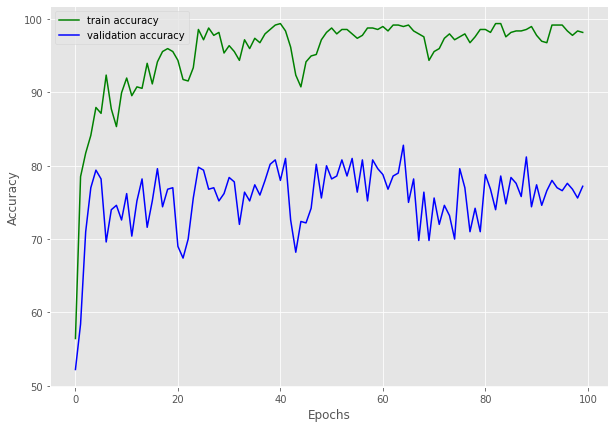

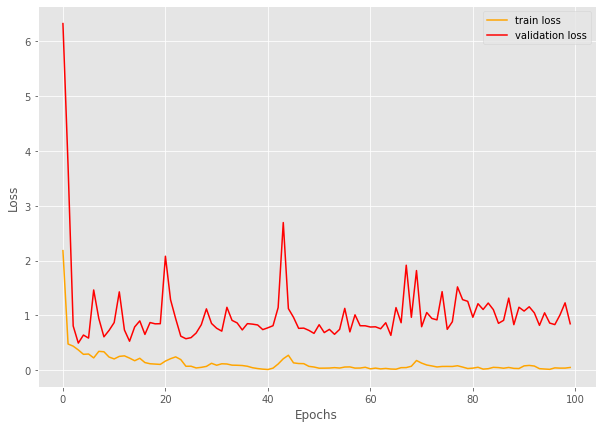

Saving model...
TRAINING COMPLETE


In [ ]:
print('Saving loss and accuracy plots...')
plt.figure(figsize=(10,7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'/content/{acc_plot_name}.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'/content/{loss_plot_name}.png')
plt.show()

print('Saving model...')
torch.save(model.state_dict(), f'/content/{model_name}.pth')
print("TRAINING COMPLETE")

- early stop(patience =15)

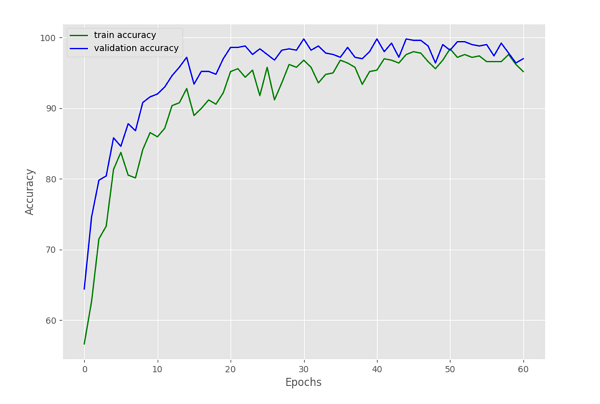

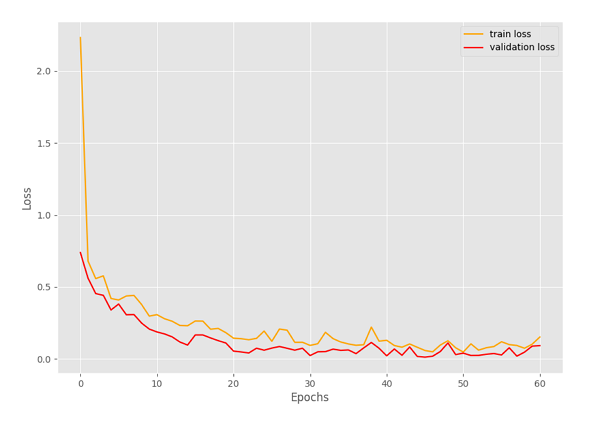

- learning rate scheduler (patience=5. lr=1e-6)

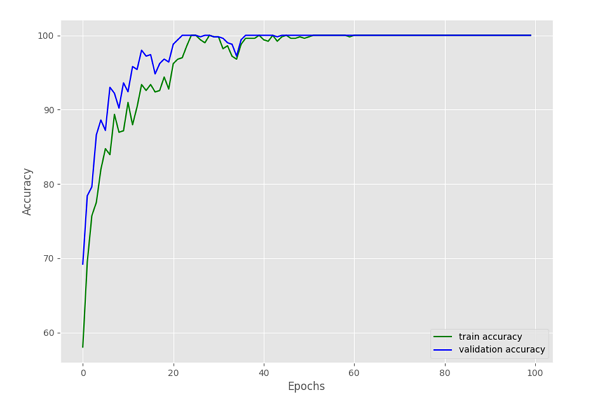

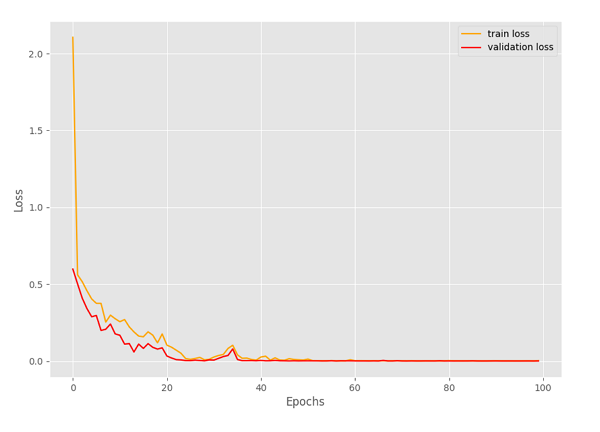